In [3]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A. Set file path to parent directory

In [17]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / "src"))
import os 
os.chdir("../")

# 1. Import data from ILO

## 1.A Import

In [5]:
import pandas as pd
from src.data.download_oecd_ilo import get_industry_employment_data

df_ilo = get_industry_employment_data(start_year=2000, end_year=2023, output_filename="ilo_data_raw.csv")
df_ilo.head(2)

/Users/angiehenon/Documents/GitHub/graspp-25S-trade/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Fetching ILO data from: https://rplumber.ilo.org/data/indicator/?id=EMP_TEMP_ECO_OCU_NB_A&timefrom=2000&timeto=2023&classif1=ECO_SECTOR_IND&classif2=OCU_SKILL_TOTAL&format=.csv
Saving the dataset to: ilo_data_raw.csv


,ref_area,source,indicator,classif1,classif2,time,obs_value,obs_status,note_classif,note_indicator,note_source
0,ABW,AA:22,EMP_TEMP_ECO_OCU_NB,ECO_SECTOR_IND,OCU_SKILL_TOTAL,2010,6.738,NaN,NaN,NaN,S3:20_T2:83
1,AFG,BA:15715,EMP_TEMP_ECO_OCU_NB,ECO_SECTOR_IND,OCU_SKILL_TOTAL,2021,1463.372,NaN,NaN,NaN,R1:3513_S3:8


## 1.1 Inspect data

In [6]:
df_ilo.ref_area.unique()

array(['ABW', 'AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT',
       'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH',
       'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA',
       'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK',
       'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU',
       'DJI', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH',
       'FIN', 'FJI', 'FRA', 'FSM', 'GBR', 'GEO', 'GHA', 'GMB', 'GNB',
       'GRC', 'GRD', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN',
       'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JOR', 'JPN', 'KEN', 'KGZ', 'KHM', 'KIR', 'KOR', 'KOS', 'LAO',
       'LBN', 'LBR', 'LCA', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC',
       'MAR', 'MDA', 'MDG', 'MDV', 'MEX', 'MHL', 'MKD', 'MLI', 'MLT',
       'MMR', 'MNE', 'MNG', 'MOZ', 'MSR', 'MUS', 'MWI', 'MYS', 'NAM',
       'NER', 'NGA', 'NIC', 'NIU', 'NLD', 'NOR', 'NPL', 'NRU', 'OMN',
       'PAK', 'PAN',

## 1.2 Truncate data

In [7]:
df_ilo_extract = df_ilo.loc[df_ilo.ref_area.isin(["USA", "FRA"]), ["ref_area", "time", "obs_value"]]
df_ilo_extract.head(2)

,ref_area,time,obs_value
627,FRA,2023,5453.964
628,FRA,2022,5389.376


In [8]:
def_ilo_renamed = df_ilo_extract.rename({"ref_area": "country", "time": "year", "obs_value": "ILO"}, axis="columns")
df_ilo_clean = def_ilo_renamed.set_index(["country", "year"])
df_ilo_clean.head(2)

ILO
country year          
FRA     2023  5453.964
        2022  5389.376

# 2. Import data from OECD

In [9]:
from src.data.download_oecd_ilo import oecd_api_wrapper

In [10]:
# https://data-explorer.oecd.org/vis?fs[0]=T%2Co&pg=0&fc=Topic&bp=true&snb=68&df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_ALFS%2540DF_SUMTAB&df[ag]=OECD.SDD.TPS&df[vs]=1.0&dq=........A&pd=%2C&to[TIME_PERIOD]=false&vw=ov
df_oecd = oecd_api_wrapper(
    agency_id="OECD.SDD.TPS",
    dataflow_id="DSD_ALFS%40DF_SUMTAB",
    dataflow_ver="1.0",
    dimensions=["all", "EMP", "PS", "all", "_T", "all", "all", "BTE", "A"],
    startPeriod=2000,
    endPeriod=2023,
    dimensionAtObservation="AllDimensions",
    format="csv",
    output_filename="oecd_data_raw.csv",
)
df_oecd.head(2)

Fetching OECD data from: https://sdmx.oecd.org/public/rest/data/OECD.SDD.TPS,DSD_ALFS%40DF_SUMTAB,1.0/.EMP.PS.._T...BTE.A?startPeriod=2000&endPeriod=2023&dimensionAtObservation=AllDimensions&format=csv
Saving the dataset to: oecd_data_raw.csv


,DATAFLOW,REF_AREA,MEASURE,UNIT_MEASURE,TRANSFORMATION,SEX,AGE,WORKER_STATUS,ACTIVITY,FREQ,TIME_PERIOD,OBS_VALUE,BASE_PER,OBS_STATUS,UNIT_MULT,DECIMALS
0,OECD.SDD.TPS:DSD_ALFS@DF_SUMTAB(1.0),JPN,EMP,PS,_Z,_T,Y_GE15,_Z,BTE,A,2012,15695.00,NaN,A,3,0
1,OECD.SDD.TPS:DSD_ALFS@DF_SUMTAB(1.0),JPN,EMP,PS,_Z,_T,Y_GE15,_Z,BTE,A,2011,15389.17,NaN,B,3,0


## 2.1 Inspect data

In [11]:
df_oecd.REF_AREA.unique()

array(['JPN', 'EST', 'LVA', 'G7', 'ITA', 'SWE', 'FRA', 'DNK', 'LTU',
       'AUS', 'USA', 'SVK', 'ISL', 'COL', 'CHE', 'NOR', 'SVN', 'FIN',
       'GRC', 'EA19', 'LUX', 'CAN', 'IRL', 'CZE', 'DEU', 'RUS', 'MEX',
       'EU27_2020', 'BEL', 'HUN', 'AUT', 'ISR', 'NZL', 'TUR', 'GBR',
       'KOR', 'BRA', 'OECD', 'NLD', 'CRI', 'CHL', 'PRT', 'POL', 'ESP'],
      dtype=object)

## 2.2 Filter data

In [12]:
df_oecd_extract = df_oecd.loc[df_oecd.REF_AREA.isin(["USA", "FRA"]), ["REF_AREA", "TIME_PERIOD", "OBS_VALUE"]]
df_oecd_extract.head(2)

,REF_AREA,TIME_PERIOD,OBS_VALUE
64,FRA,2021,5252.70
65,FRA,2022,5373.95


In [13]:
df_oecd_renamed = df_oecd_extract.rename({"REF_AREA": "country", "TIME_PERIOD": "year", "OBS_VALUE": "OECD"}, axis="columns")
df_oecd_clean = df_oecd_renamed.set_index(["country", "year"])
df_oecd_clean.head(2)

OECD
country year         
FRA     2021  5252.70
        2022  5373.95

# Merge data

In [14]:
df_merge = pd.merge(
    df_ilo_clean,
    df_oecd_clean,
    right_index = True,
    left_index = True,
    how = 'inner'
)
df_merge.head(2)

ILO     OECD
country year                   
FRA     2023  5453.964  5453.95
        2022  5389.376  5373.95

In [15]:
df_melt = pd.melt(df_merge.reset_index(), id_vars=["country", "year"], value_vars=["ILO", "OECD"], var_name="source", value_name="employment")
df_melt.head(2)

,country,year,source,employment
0,FRA,2023,ILO,5453.964
1,FRA,2022,ILO,5389.376


# Graph data

Matplotlib is building the font cache; this may take a moment.


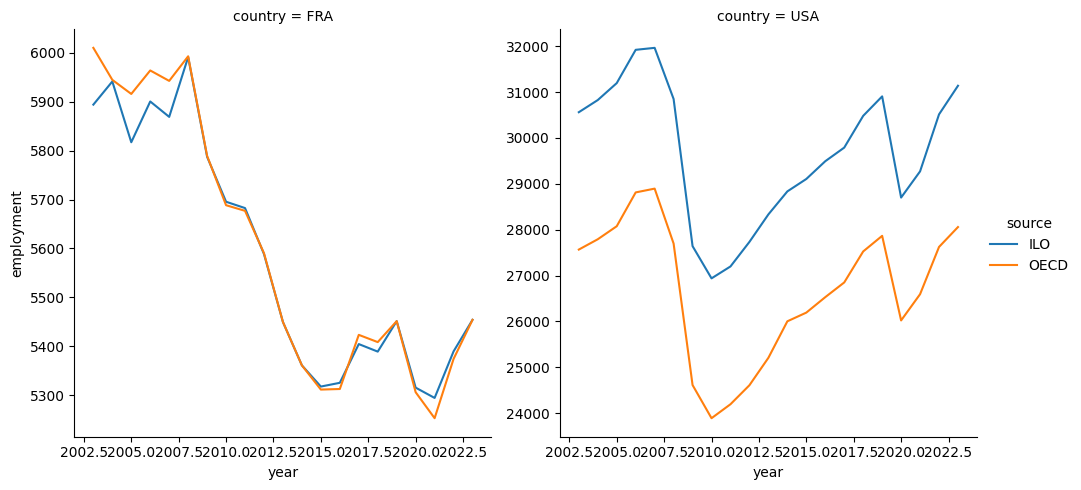

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

g = FacetGrid(1,2,sharey=False)
g = sns.relplot(data=df_melt, x="year", y="employment", hue="source", col="country", kind="line", facet_kws={'sharey': False})
g.set


# CAN YOU PLEASE DESCRIBE THE COMTRAD DATA 

- Were you unable to download it from the comtrad API?
    - Please